In [1]:
%matplotlib inline
import glob
import os
import pprint as pp
import warnings

import framskrivning_vann as fv
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn
import teotil2 as teo

plt.style.use("ggplot")
warnings.simplefilter("ignore")

In [2]:
# Connect to db
eng = nivapy.da.connect()

Username:  ···
Password:  ········


Connection successful.


# Framskrivning Vann

This notebook runs the [TEOTIL2](https://nivanorge.github.io/teotil2/) model to explore possible effects of changing land use and management practices on riverine fluxes of total nitrogen (N) and totoal phosphorus (P). The work is undertaken as part of the **Framskrivning Vann** project.

Starting from a "baseline" of 2016 agricultural practices, NIBIO have generated a set of future land use and management scenarios for Norway for 2020, 2025 and 2030. 

The code below runs the TEOTIL2 model for the period from 1995 to 2030:

 * For 1995 to 2015 inclusive, the model is run using input data extracted directly from NIVA's database (i.e. the same workflow as for the [RID programme](https://github.com/JamesSample/rid))
 
 * For 2016, 2020, 2025 and 2030, the model is run using agrcultural data supplied by NIBIO in Excel format (see e-mail from Øyvind received 14.12.2020 at 20.37), with all other inputs (non-agricultural sources, hydrology etc.) fixed at 2016 values
 
Results are summarised over four "vannregioner", which are also used in the annual TEOTIL report (previously written by John Rune, but now taken over by Jose): Glomma, Vest-Viken, Rogaland and Trøndelag.

In [3]:
# Base year for future simulations (other inputs, hydrology etc.)
base_year = 2016

# Years of interest
years = list(range(1995, 2016)) + [base_year, 2020, 2025, 2030]

# Parameters of interest
par_list = ["Tot-N", "Tot-P"]

# Folder containing TEOTIL2 data files
data_fold = r"../../../Elveovervakingsprogrammet/teotil2/data/core_input_data"

# NIBIO agricultural scenarios
nibio_xl_path = r"../data/nibio_jordbruk_2016_2020_2025_2030.xlsx"

## 1. Generate input files for TEOTIL2

In [4]:
# Make input files
for year in years:
    ann_csv = f"../data/teotil_input_data_{year}.csv"

    if year < base_year:
        # Create input file as normal
        df = teo.io.make_input_file(
            year, eng, data_fold, ann_csv, mode="nutrients", par_list=par_list
        )
    else:
        # Use the adapted function for this project, which uses modified agricultural inputs
        # but takes everything else from 'base_year'
        df = fv.make_rid_input_file(
            base_year,
            eng,
            data_fold,
            ann_csv,
            nibio_xl_path,
            str(year),
            par_list=par_list,
        )

## 2. Run model

In [5]:
%%time
res_dict = {}
for year in years:
    # Run model
    ann_csv = f"../data/teotil_input_data_{year}.csv"
    g = teo.model.run_model(ann_csv)

    # Save
    out_csv = f"../data/teotil2_results_{year}.csv"
    df = teo.model.model_to_dataframe(g, out_path=out_csv)

    res_dict[year] = df

CPU times: user 3min 53s, sys: 3.46 s, total: 3min 57s
Wall time: 4min 17s


## 3. Extract output for regions of interest

In [6]:
# Catchments for regions of interest as defined by John Rune in e.g.
# K:\Prosjekter\Ferskvann\O-13255-TEOTIL\Tabeller\PogN i rapporten.xlsx
# Ranges are inclusive
reg_dict = {
    "Glomma": [1, 10],
    "Vest-Viken": [11, 17],
    "Rogaland": [27, 40],
    "Trøndelag": [117, 143],
}

# Loop over all data
row_list = []
for par in par_list:
    # Aggregations for output quantities of interest
    teotil_report_par_map = {
        "Akvakultur": [f"accum_aqu_{par.lower()}_tonnes"],
        "Jordbruk": [
            f"accum_agri_diff_{par.lower()}_tonnes",
            f"accum_agri_pt_{par.lower()}_tonnes",
        ],
        "Befolkning": [
            f"accum_ren_{par.lower()}_tonnes",
            f"accum_spr_{par.lower()}_tonnes",
        ],
        "Industri": [f"accum_ind_{par.lower()}_tonnes"],
        "Bakgrunn": [f"accum_nat_diff_{par.lower()}_tonnes"],
        "Totalt": [f"accum_all_sources_{par.lower()}_tonnes"],
        "Menneskeskapt": [
            f"accum_anth_diff_{par.lower()}_tonnes",
            f"accum_all_point_{par.lower()}_tonnes",
        ],
        "Urban": [f"accum_urban_{par.lower()}_tonnes"],
    }

    for year in years:
        # Get model results for this year
        df = res_dict[year].copy()
        df.set_index("regine", inplace=True)

        # Loop over regions
        for reg, cat_list in reg_dict.items():
            first, last = cat_list

            # Dict to keep track of totals
            tot_dict = {key: 0 for key in teotil_report_par_map.keys()}
            tot_dict["Par"] = par
            tot_dict["Year"] = year
            tot_dict["Region"] = reg

            # Loop over catchments in each region
            for cat_id in range(first, last + 1):
                for src, cols in teotil_report_par_map.items():
                    for col in cols:
                        # Get accumulated totals for each catchment and increment region total
                        tot_dict[src] += df.loc[f"{cat_id:03d}.", col]

            row_list.append(tot_dict.copy())

# Build dataframe
df = pd.DataFrame(row_list)
cols = ["Par", "Year", "Region"] + [i for i in sorted(teotil_report_par_map.keys())]
df = df[cols]
df = df.round(1)

# Save
csv_path = r"../output/teotil_framskrivning_vann_summary_fluxes_tonnes.csv"
df.to_csv(csv_path, index=False)

df.head()

,Par,Year,Region,Akvakultur,Bakgrunn,Befolkning,Industri,Jordbruk,Menneskeskapt,Totalt,Urban
0,Tot-N,1995,Glomma,1.0,7000.1,6217.3,375.1,9192.6,15955.9,22956.0,169.8
1,Tot-N,1995,Vest-Viken,5.4,6879.7,2441.0,1411.0,4284.9,8224.5,15104.2,82.1
2,Tot-N,1995,Rogaland,681.2,6158.8,1879.4,351.0,3067.3,6002.9,12161.7,24.1
3,Tot-N,1995,Trøndelag,2051.8,7598.5,1875.1,94.6,3691.7,7734.0,15332.5,20.9
4,Tot-N,1996,Glomma,1.3,5541.0,5758.0,184.9,9082.2,15196.1,20737.1,169.8


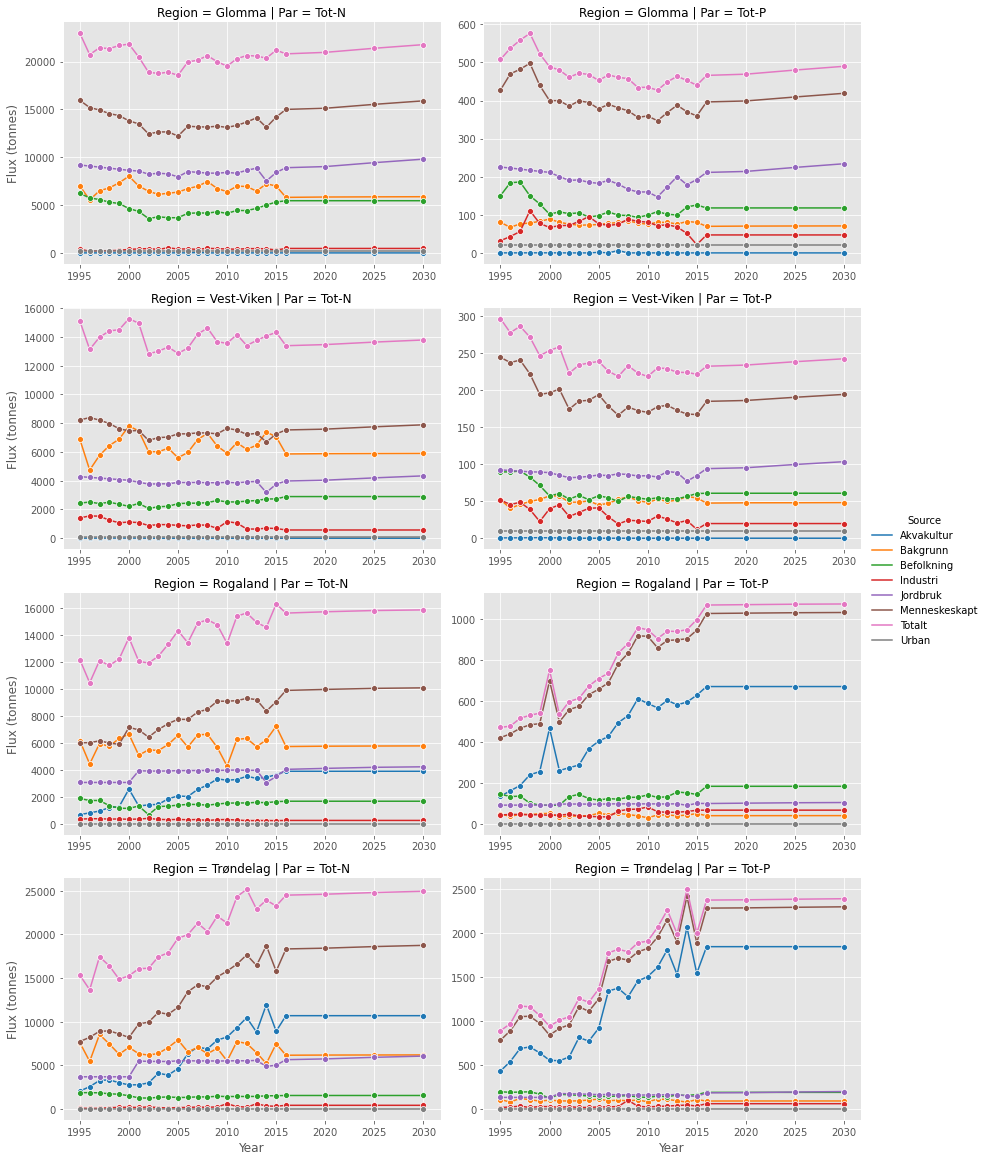

In [7]:
# Melt
df_long = df.melt(
    id_vars=["Par", "Year", "Region"], var_name="Source", value_name="Flux (tonnes)"
)
sn.set_palette("tab10")
sn.relplot(
    data=df_long,
    x="Year",
    y="Flux (tonnes)",
    col="Par",
    hue="Source",
    row="Region",
    kind="line",
    marker="o",
    facet_kws={"sharey": False, "sharex": False},
    aspect=1.5,
    height=4,
)

# Save
png_path = r"../output/teotil_framskrivning_vann_summary_fluxes.png"
plt.savefig(png_path, dpi=300)

In [8]:
# Delete input CSVs and results files from repo
search_path = r"../data/*.csv"
flist = glob.glob(search_path)
for fpath in flist:
    os.remove(fpath)

In [9]:
# Express values relative to 2016
df_list = []
for par in par_list:
    for reg in reg_dict.keys():
        par_reg_df = df.query("(Par == @par) and (Region == @reg)").copy()
        
        par_reg_df_2016 = df.query("(Par == @par) and (Region == @reg) and (Year == 2016)").copy()
            
        for col in par_reg_df.columns:
            if col not in ['Par', 'Region', 'Year']:
                par_reg_df[col] = 100 * par_reg_df[col] / par_reg_df_2016[col].iloc[0]
        
        df_list.append(par_reg_df)

df_rel_2016 = pd.concat(df_list, axis='rows')

# Save
csv_path = r"../output/teotil_framskrivning_vann_summary_fluxes_relative_2016.csv"
df_rel_2016.to_csv(csv_path, index=False)